
  BACKTEST FINAL COM POSITION SIZING E COOLDOWN  
Capital Inicial: R$ 5000.00
Capital Final: R$ 7215.50
Lucro Líquido Total: R$ 2215.50
Total de Trades: 97
Taxa de Acerto: 49.48%
Drawdown Máximo: 19.03%


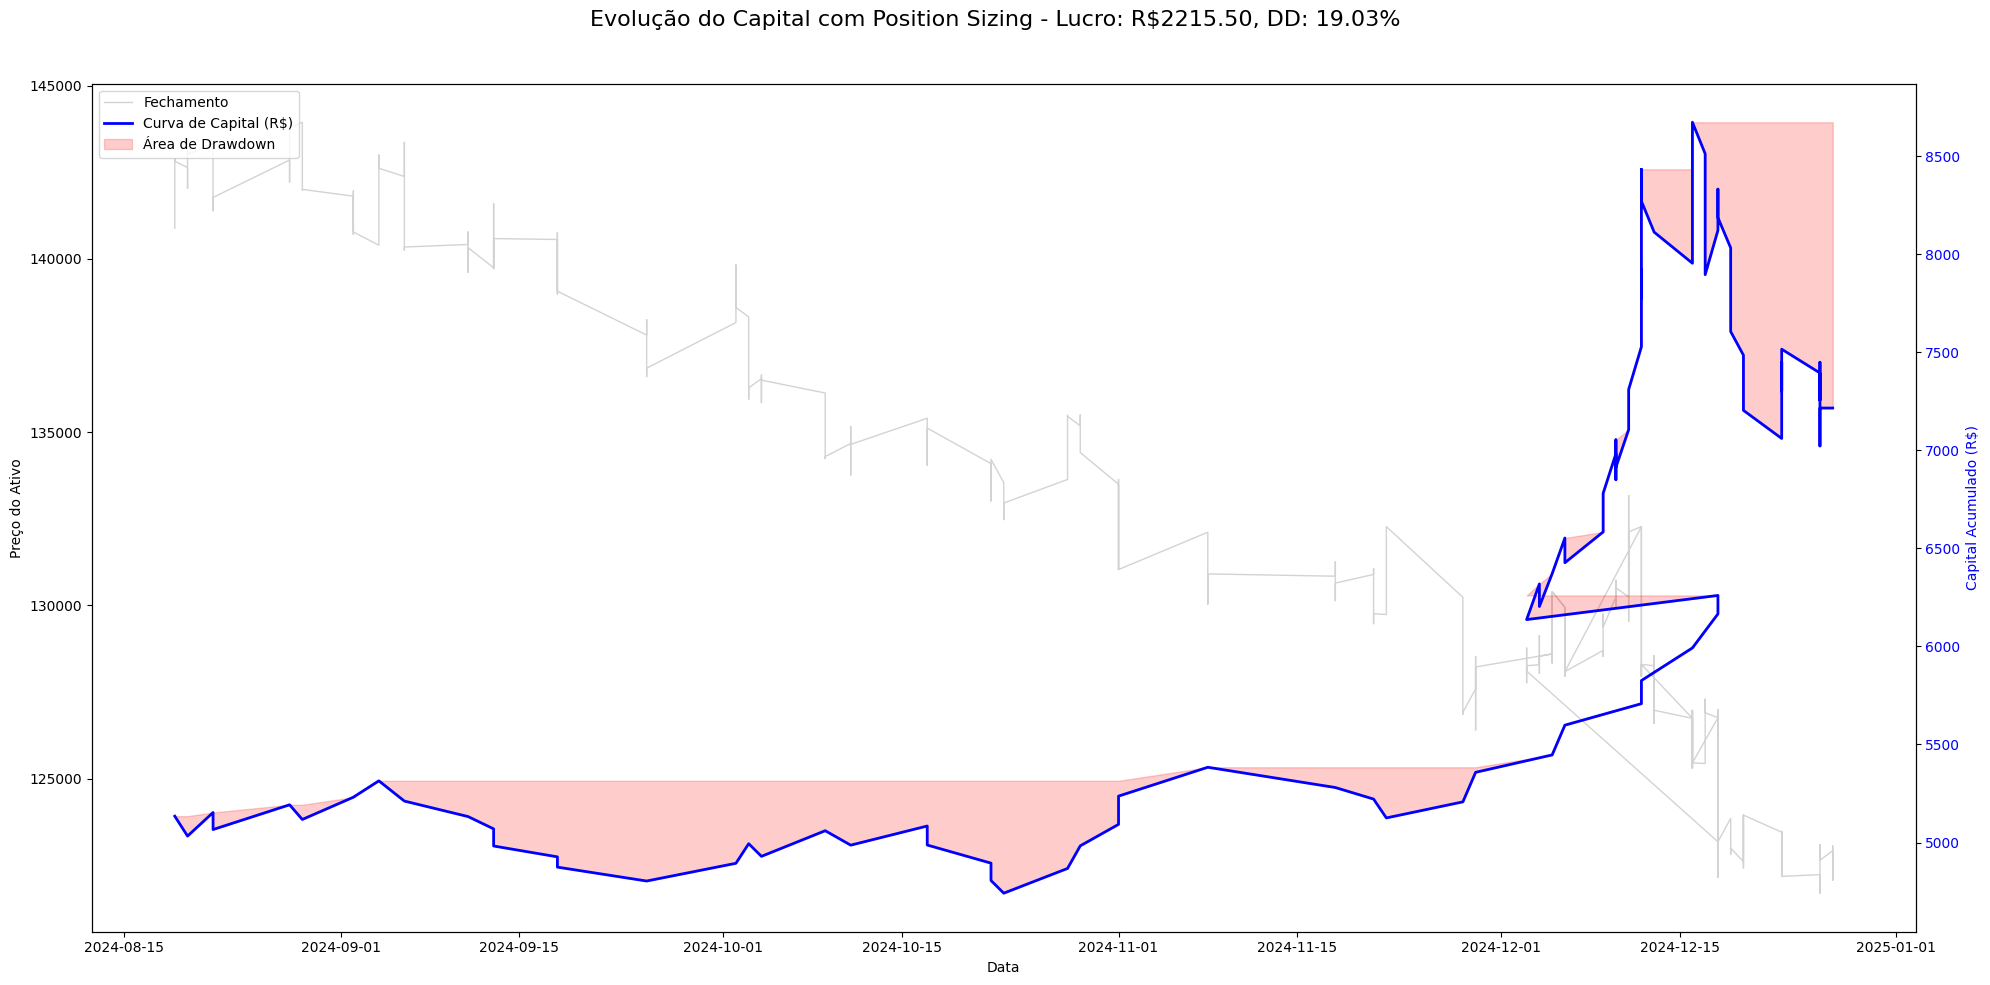

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# --- FUNÇÕES DE CÁLCULO E DETECÇÃO (Sem alterações) ---
def calcular_atr(df, periodo=14):
    df_atr = df.copy()
    df_atr['H-L'] = df_atr['Alta'] - df_atr['Baixa']
    df_atr['H-pC'] = abs(df_atr['Alta'] - df_atr['Fechamento'].shift(1))
    df_atr['L-pC'] = abs(df_atr['Baixa'] - df_atr['Fechamento'].shift(1))
    df_atr['TR'] = df_atr[['H-L', 'H-pC', 'L-pC']].max(axis=1)
    df_atr['ATR'] = df_atr['TR'].ewm(span=periodo, adjust=False).mean()
    return df_atr.drop(columns=['H-L', 'H-pC', 'L-pC'])

def calcular_adx(df, periodo=14):
    df_adx = df.copy()
    df_adx['H-L'] = df_adx['Alta'] - df_adx['Baixa']
    df_adx['H-pC'] = abs(df_adx['Alta'] - df_adx['Fechamento'].shift(1))
    df_adx['L-pC'] = abs(df_adx['Baixa'] - df_adx['Fechamento'].shift(1))
    df_adx['TR'] = df_adx[['H-L', 'H-pC', 'L-pC']].max(axis=1)
    df_adx['+DM'] = np.where((df_adx['Alta'] - df_adx['Alta'].shift(1)) > (df_adx['Baixa'].shift(1) - df_adx['Baixa']), df_adx['Alta'] - df_adx['Alta'].shift(1), 0)
    df_adx['+DM'] = np.where(df_adx['+DM'] < 0, 0, df_adx['+DM'])
    df_adx['-DM'] = np.where((df_adx['Baixa'].shift(1) - df_adx['Baixa']) > (df_adx['Alta'] - df_adx['Alta'].shift(1)), df_adx['Baixa'].shift(1) - df_adx['Baixa'], 0)
    df_adx['-DM'] = np.where(df_adx['-DM'] < 0, 0, df_adx['-DM'])
    ATR_temp = df_adx['TR'].ewm(alpha=1/periodo, adjust=False).mean()
    df_adx['+DI'] = (df_adx['+DM'].ewm(alpha=1/periodo, adjust=False).mean() / ATR_temp) * 100
    df_adx['-DI'] = (df_adx['-DM'].ewm(alpha=1/periodo, adjust=False).mean() / ATR_temp) * 100
    dx = (abs(df_adx['+DI'] - df_adx['-DI']) / (df_adx['+DI'] + df_adx['-DI'])).fillna(0) * 100
    df_adx['ADX'] = dx.ewm(alpha=1/periodo, adjust=False).mean()
    return df_adx.drop(columns=['H-L', 'H-pC', 'L-pC', 'TR', '+DM', '-DM'])

def identificar_pivos_robustos(df, periodo_verificacao=8):
    topos = []; fundos = []
    janela_alta = deque(maxlen=2 * periodo_verificacao + 1); janela_baixa = deque(maxlen=2 * periodo_verificacao + 1); indices_janela = deque(maxlen=2 * periodo_verificacao + 1)
    for i in range(len(df)):
        janela_alta.append(df['Alta'].iloc[i]); janela_baixa.append(df['Baixa'].iloc[i]); indices_janela.append(i)
        if len(janela_alta) == 2 * periodo_verificacao + 1:
            indice_central = indices_janela[periodo_verificacao]; preco_central_alta = janela_alta[periodo_verificacao]; preco_central_baixa = janela_baixa[periodo_verificacao]
            if preco_central_alta == max(janela_alta): topos.append((indice_central, preco_central_alta))
            if preco_central_baixa == min(janela_baixa): fundos.append((indice_central, preco_central_baixa))
    pivos_alta_confirmados = []
    if len(fundos) >= 2 and len(topos) >= 1:
        for i in range(len(topos)):
            for j in range(len(fundos) - 1):
                p1_idx, p1_preco = fundos[j]; p2_idx, p2_preco = topos[i]; p3_idx, p3_preco = fundos[j+1]
                if (p1_idx < p2_idx < p3_idx) and (p3_preco > p1_preco):
                    for k in range(p3_idx + 1, len(df)):
                        if df['Alta'].iloc[k] > p2_preco:
                            pivos_alta_confirmados.append({'ponto1': p1_preco, 'ponto2': p2_preco, 'ponto3': p3_preco, 'indice_rompimento': k}); break
    pivos_baixa_confirmados = []
    if len(topos) >= 2 and len(fundos) >= 1:
        for i in range(len(fundos)):
            for j in range(len(topos) - 1):
                p1_idx, p1_preco = topos[j]; p2_idx, p2_preco = fundos[i]; p3_idx, p3_preco = topos[j+1]
                if (p1_idx < p2_idx < p3_idx) and (p3_preco < p1_preco):
                    for k in range(p3_idx + 1, len(df)):
                        if df['Baixa'].iloc[k] < p2_preco:
                            pivos_baixa_confirmados.append({'ponto1': p1_preco, 'ponto2': p2_preco, 'ponto3': p3_preco, 'indice_rompimento': k}); break
    pivos_alta_final = []; seen_alta = set()
    for pivo in pivos_alta_confirmados:
        identifier = (pivo['ponto1'], pivo['ponto2'], pivo['ponto3'], pivo['indice_rompimento'])
        if identifier not in seen_alta: seen_alta.add(identifier); pivos_alta_final.append(pivo)
    pivos_baixa_final = []; seen_baixa = set()
    for pivo in pivos_baixa_confirmados:
        identifier = (pivo['ponto1'], pivo['ponto2'], pivo['ponto3'], pivo['indice_rompimento'])
        if identifier not in seen_baixa: seen_baixa.add(identifier); pivos_baixa_final.append(pivo)
    pivos_alta_final.sort(key=lambda x: x['indice_rompimento']); pivos_baixa_final.sort(key=lambda x: x['indice_rompimento'])
    return pivos_alta_final, pivos_baixa_final

# --- NOVA FUNÇÃO DE SIMULAÇÃO CRONOLÓGICA ---
def simulacao_final(df, pivos_alta, pivos_baixa, capital_inicial, risco_por_trade, custo_por_contrato, periodo_cooldown, params):
    # Junta e ordena todos os sinais de trade por data
    for p in pivos_alta: p['tipo_sinal'] = 'alta'
    for p in pivos_baixa: p['tipo_sinal'] = 'baixa'
    todos_sinais = sorted(pivos_alta + pivos_baixa, key=lambda x: x['indice_rompimento'])

    capital_corrente = capital_inicial
    trades_executados = []
    cooldown_ate_indice = 0 # Inicia o cooldown em zero

    for sinal in todos_sinais:
        indice_rompimento = sinal['indice_rompimento']
        indice_entrada = indice_rompimento + 1

        if indice_entrada >= len(df): continue
        
        # --- VERIFICAÇÃO DO COOLDOWN ---
        if indice_entrada < cooldown_ate_indice:
            continue # Pula o sinal se a estratégia estiver em período de descanso

        # Filtro triplo de qualidade
        ema_rapida = df['ema_rapida'].iloc[indice_entrada]; ema_lenta = df['ema_lenta'].iloc[indice_entrada]
        adx = df['ADX'].iloc[indice_entrada]; di_pos = df['+DI'].iloc[indice_entrada]; di_neg = df['-DI'].iloc[indice_entrada]
        
        condicao_valida = False
        if sinal['tipo_sinal'] == 'alta' and ema_rapida > ema_lenta and adx > params['adx_minimo'] and di_pos > di_neg: condicao_valida = True
        elif sinal['tipo_sinal'] == 'baixa' and ema_rapida < ema_lenta and adx > params['adx_minimo'] and di_neg > di_pos: condicao_valida = True
        
        if not condicao_valida: continue

        # --- CÁLCULO DO TAMANHO DA POSIÇÃO ---
        preco_entrada = df['Abertura'].iloc[indice_entrada]
        atr_no_ponto = df['ATR'].iloc[indice_entrada]
        
        distancia_stop_pontos = params['multiplicador_atr'] * atr_no_ponto
        if distancia_stop_pontos == 0: continue # Evita divisão por zero

        risco_monetario_por_contrato = distancia_stop_pontos * 0.20
        risco_maximo_capital = capital_corrente * risco_por_trade
        
        if capital_corrente < custo_por_contrato:
            print("Capital insuficiente para abrir nova posição. Fim da simulação.")
            break # Encerra se não há capital nem para a margem de 1 contrato

        tamanho_posicao = int(risco_maximo_capital / risco_monetario_por_contrato)
        
        # Garante que temos margem para a posição calculada
        if tamanho_posicao * custo_por_contrato > capital_corrente:
            tamanho_posicao = int(capital_corrente / custo_por_contrato) # Reduz para o máximo possível

        if tamanho_posicao < 1:
            continue # Pula se não for possível abrir nem 1 contrato
        
        # --- SIMULAÇÃO DO TRADE ---
        distancia_alvo_pontos = distancia_stop_pontos * params['relacao_risco_retorno']
        if sinal['tipo_sinal'] == 'alta':
            preco_stop = preco_entrada - distancia_stop_pontos; preco_alvo = preco_entrada + distancia_alvo_pontos
        else:
            preco_stop = preco_entrada + distancia_stop_pontos; preco_alvo = preco_entrada - distancia_alvo_pontos

        trade_info = {"Data": df.index[indice_entrada], "Tipo": sinal['tipo_sinal'].upper(), "Posicao (Contratos)": tamanho_posicao, "P/L (R$)": 0.0}
        
        for i in range(indice_entrada, len(df)):
            candle_high, candle_low = df['Alta'].iloc[i], df['Baixa'].iloc[i]
            pl_trade = 0
            trade_fechado = False

            if sinal['tipo_sinal'] == 'alta':
                if candle_low <= preco_stop: 
                    pl_trade = -abs(preco_stop - preco_entrada) * 0.20 * tamanho_posicao
                    trade_fechado = True
                elif candle_high >= preco_alvo:
                    pl_trade = abs(preco_alvo - preco_entrada) * 0.20 * tamanho_posicao
                    trade_fechado = True
            else: # Baixa
                if candle_high >= preco_stop:
                    pl_trade = -abs(preco_stop - preco_entrada) * 0.20 * tamanho_posicao
                    trade_fechado = True
                elif candle_low <= preco_alvo:
                    pl_trade = abs(preco_alvo - preco_entrada) * 0.20 * tamanho_posicao
                    trade_fechado = True

            if trade_fechado:
                capital_corrente += pl_trade
                trade_info["P/L (R$)"] = pl_trade
                cooldown_ate_indice = i + 1 + periodo_cooldown # ATIVA O COOLDOWN
                break
        
        trades_executados.append(trade_info)

    return trades_executados

if __name__ == "__main__":
    try:
        df_original = pd.read_excel(r"c:\Users\danie\OneDrive\Área de Trabalho\Todas as pastas\Treinamento Modelo\renko_teste.xlsm", sheet_name="Destino")
        df_original['Data'] = pd.to_datetime(df_original['Data'], dayfirst=True)
        df_original = df_original.loc[~df_original.index.duplicated(keep='first')]; df_original = df_original.set_index('Data')
    except FileNotFoundError:
        print("Arquivo não encontrado."); df_original = pd.DataFrame()

    # --- PARÂMETROS DA ESTRATÉGIA FINAL ---
    CAPITAL_INICIAL = 5000.0
    RISCO_POR_TRADE = 0.02  # Risco de 2% do capital por operação
    CUSTO_POR_CONTRATO = 25.0 # Margem de R$ 25 por mini contrato
    PERIODO_COOLDOWN = 5      # Espera 5 candles/boxes após fechar um trade

    PARAMETROS_OTIMIZADOS = {
        'relacao_risco_retorno': 1.5,
        'multiplicador_atr': 1.5,
        'adx_minimo': 30
    }

    df = df_original.copy()
    df['ema_rapida'] = df['Fechamento'].ewm(span=21, adjust=False).mean()
    df['ema_lenta'] = df['Fechamento'].ewm(span=50, adjust=False).mean()
    df = calcular_adx(df); df = calcular_atr(df); df.dropna(inplace=True)

    lista_pivos_alta, lista_pivos_baixa = identificar_pivos_robustos(df, periodo_verificacao=8)
    
    # --- EXECUÇÃO DA SIMULAÇÃO FINAL ---
    trades_finais = simulacao_final(df, lista_pivos_alta, lista_pivos_baixa, CAPITAL_INICIAL, RISCO_POR_TRADE, CUSTO_POR_CONTRATO, PERIODO_COOLDOWN, PARAMETROS_OTIMIZADOS)
    
    if trades_finais:
        capital_df = pd.DataFrame(trades_finais).set_index("Data")
        capital_df['Capital Acumulado'] = CAPITAL_INICIAL + capital_df['P/L (R$)'].cumsum()
        capital_df['Pico Capital'] = capital_df['Capital Acumulado'].cummax()
        capital_df['Drawdown (R$)'] = capital_df['Pico Capital'] - capital_df['Capital Acumulado']
        capital_df['Drawdown (%)'] = np.where(capital_df['Pico Capital'] > 0, (capital_df['Drawdown (R$)'] / capital_df['Pico Capital']) * 100, 0)
        
        # --- Relatório Final ---
        lucro_final = capital_df['Capital Acumulado'].iloc[-1] - CAPITAL_INICIAL
        max_dd_percent = capital_df['Drawdown (%)'].max()
        
        print("\n" + "="*50); print("  BACKTEST FINAL COM POSITION SIZING E COOLDOWN  "); print("="*50)
        print(f"Capital Inicial: R$ {CAPITAL_INICIAL:.2f}")
        print(f"Capital Final: R$ {capital_df['Capital Acumulado'].iloc[-1]:.2f}")
        print(f"Lucro Líquido Total: R$ {lucro_final:.2f}")
        print(f"Total de Trades: {len(trades_finais)}")
        print(f"Taxa de Acerto: {(capital_df['P/L (R$)'] > 0).sum() / len(trades_finais) * 100:.2f}%")
        print(f"Drawdown Máximo: {max_dd_percent:.2f}%")
        
        # --- Plotagem ---
        fig, ax1 = plt.subplots(figsize=(20, 10))
        ax1.plot(df.loc[capital_df.index].index, df.loc[capital_df.index]['Fechamento'], label='Fechamento', color='lightgray', linewidth=1)
        ax1.set_xlabel("Data"); ax1.set_ylabel("Preço do Ativo")
        
        ax2 = ax1.twinx()
        ax2.plot(capital_df.index, capital_df['Capital Acumulado'], label='Curva de Capital (R$)', color='blue', linewidth=2)
        ax2.fill_between(capital_df.index, capital_df['Capital Acumulado'], capital_df['Pico Capital'], color='red', alpha=0.2, label='Área de Drawdown')
        ax2.set_ylabel('Capital Acumulado (R$)', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        fig.suptitle(f"Evolução do Capital com Position Sizing - Lucro: R${lucro_final:.2f}, DD: {max_dd_percent:.2f}%", fontsize=16)
        lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')
        fig.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

Calculando indicadores...
Indicadores calculados com sucesso.

                  LOG DE TRADES EXECUTADOS
| Nº   | Data Ent.    | Tipo    | Resultado  | P/L (R$)   |
-----------------------------------------------------------
| 1    | 2024-08-19   | ALTA    | LUCRO      | R$44.78     |
| 2    | 2024-08-19   | ALTA    | PREJUÍZO   | R$-24.03    |
| 3    | 2024-08-20   | ALTA    | PREJUÍZO   | R$-25.38    |
| 4    | 2024-08-22   | BAIXA   | LUCRO      | R$60.16     |
| 5    | 2024-08-22   | BAIXA   | PREJUÍZO   | R$-43.47    |
| 6    | 2024-08-26   | ALTA    | PREJUÍZO   | R$-35.33    |
| 7    | 2024-08-26   | ALTA    | PREJUÍZO   | R$-24.05    |
| 8    | 2024-08-27   | BAIXA   | LUCRO      | R$32.35     |
| 9    | 2024-08-28   | BAIXA   | LUCRO      | R$63.08     |
| 10   | 2024-08-28   | BAIXA   | LUCRO      | R$63.08     |
| 11   | 2024-08-29   | BAIXA   | PREJUÍZO   | R$-37.42    |
| 12   | 2024-08-29   | BAIXA   | PREJUÍZO   | R$-37.42    |
| 13   | 2024-08-29   | BAIXA   | LUCRO   

C:\Users\danie\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


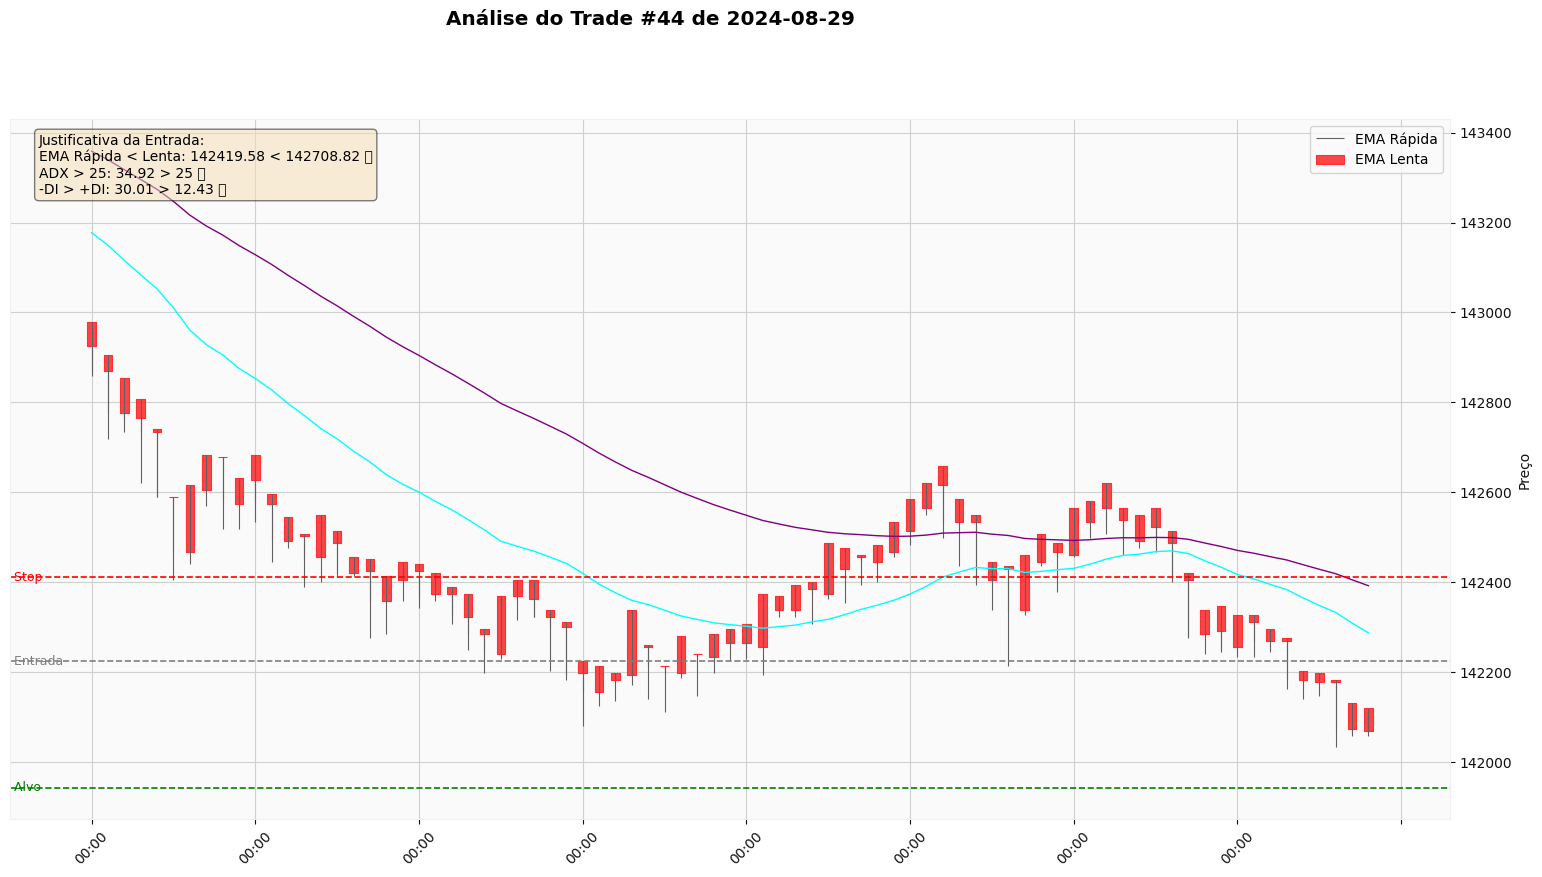

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import mplfinance as mpf

# --- FUNÇÕES DE CÁLCULO E DETECÇÃO ---
def calcular_atr(df, periodo=14):
    df_atr = df.copy()
    df_atr['H-L'] = df_atr['Alta'] - df_atr['Baixa']
    df_atr['H-pC'] = abs(df_atr['Alta'] - df_atr['Fechamento'].shift(1))
    df_atr['L-pC'] = abs(df_atr['Baixa'] - df_atr['Fechamento'].shift(1))
    df_atr['TR'] = df_atr[['H-L', 'H-pC', 'L-pC']].max(axis=1)
    df_atr['ATR'] = df_atr['TR'].ewm(span=periodo, adjust=False).mean()
    return df_atr[['ATR']]

def calcular_adx(df, periodo=14):
    df_adx = df.copy()
    df_adx['H-L'] = df_adx['Alta'] - df_adx['Baixa']
    df_adx['H-pC'] = abs(df_adx['Alta'] - df_adx['Fechamento'].shift(1))
    df_adx['L-pC'] = abs(df_adx['Baixa'] - df_adx['Fechamento'].shift(1))
    df_adx['TR'] = df_adx[['H-L', 'H-pC', 'L-pC']].max(axis=1)
    df_adx['+DM'] = np.where((df_adx['Alta'] - df_adx['Alta'].shift(1)) > (df_adx['Baixa'].shift(1) - df_adx['Baixa']), df_adx['Alta'] - df_adx['Alta'].shift(1), 0)
    df_adx['+DM'] = np.where(df_adx['+DM'] < 0, 0, df_adx['+DM'])
    df_adx['-DM'] = np.where((df_adx['Baixa'].shift(1) - df_adx['Baixa']) > (df_adx['Alta'] - df_adx['Alta'].shift(1)), df_adx['Baixa'].shift(1) - df_adx['Baixa'], 0)
    df_adx['-DM'] = np.where(df_adx['-DM'] < 0, 0, df_adx['-DM'])
    ATR_temp = df_adx['TR'].ewm(alpha=1/periodo, adjust=False).mean()
    df_adx['+DI'] = ((df_adx['+DM'].ewm(alpha=1/periodo, adjust=False).mean() / ATR_temp) * 100).fillna(0)
    df_adx['-DI'] = ((df_adx['-DM'].ewm(alpha=1/periodo, adjust=False).mean() / ATR_temp) * 100).fillna(0)
    dx = (abs(df_adx['+DI'] - df_adx['-DI']) / (df_adx['+DI'] + df_adx['-DI'])).fillna(0) * 100
    df_adx['ADX'] = dx.ewm(alpha=1/periodo, adjust=False).mean()
    return df_adx[['+DI', '-DI', 'ADX']]

def identificar_pivos_robustos(df, periodo_verificacao=8):
    topos = []; fundos = []
    janela_alta = deque(maxlen=2 * periodo_verificacao + 1); janela_baixa = deque(maxlen=2 * periodo_verificacao + 1); indices_janela = deque(maxlen=2 * periodo_verificacao + 1)
    for i in range(len(df)):
        janela_alta.append(df['Alta'].iloc[i]); janela_baixa.append(df['Baixa'].iloc[i]); indices_janela.append(i)
        if len(janela_alta) == 2 * periodo_verificacao + 1:
            indice_central = indices_janela[periodo_verificacao]; preco_central_alta = janela_alta[periodo_verificacao]; preco_central_baixa = janela_baixa[periodo_verificacao]
            if preco_central_alta == max(janela_alta): topos.append((indice_central, preco_central_alta))
            if preco_central_baixa == min(janela_baixa): fundos.append((indice_central, preco_central_baixa))
    pivos_alta_confirmados = []; pivos_baixa_confirmados = []
    if len(fundos) >= 2 and len(topos) >= 1:
        for i in range(len(topos)):
            for j in range(len(fundos) - 1):
                p1_idx, p1_preco = fundos[j]; p2_idx, p2_preco = topos[i]; p3_idx, p3_preco = fundos[j+1]
                if (p1_idx < p2_idx < p3_idx) and (p3_preco > p1_preco):
                    for k in range(p3_idx + 1, len(df)):
                        if df['Alta'].iloc[k] > p2_preco: pivos_alta_confirmados.append({'ponto1': p1_preco, 'ponto2': p2_preco, 'ponto3': p3_preco, 'indice_rompimento': k}); break
    if len(topos) >= 2 and len(fundos) >= 1:
        for i in range(len(fundos)):
            for j in range(len(topos) - 1):
                p1_idx, p1_preco = topos[j]; p2_idx, p2_preco = fundos[i]; p3_idx, p3_preco = topos[j+1]
                if (p1_idx < p2_idx < p3_idx) and (p3_preco < p1_preco):
                    for k in range(p3_idx + 1, len(df)):
                        if df['Baixa'].iloc[k] < p2_preco: pivos_baixa_confirmados.append({'ponto1': p1_preco, 'ponto2': p2_preco, 'ponto3': p3_preco, 'indice_rompimento': k}); break
    pivos_alta_final = []; seen_alta = set()
    for pivo in pivos_alta_confirmados:
        identifier = (pivo['ponto1'], pivo['ponto2'], pivo['ponto3'], pivo['indice_rompimento'])
        if identifier not in seen_alta: seen_alta.add(identifier); pivos_alta_final.append(pivo)
    pivos_baixa_final = []; seen_baixa = set()
    for pivo in pivos_baixa_confirmados:
        identifier = (pivo['ponto1'], pivo['ponto2'], pivo['ponto3'], pivo['indice_rompimento'])
        if identifier not in seen_baixa: seen_baixa.add(identifier); pivos_baixa_final.append(pivo)
    pivos_alta_final.sort(key=lambda x: x['indice_rompimento']); pivos_baixa_final.sort(key=lambda x: x['indice_rompimento'])
    return pivos_alta_final, pivos_baixa_final

def simulacao_para_analise(df, pivos_alta, pivos_baixa, params):
    for p in pivos_alta: p['tipo_sinal'] = 'alta'
    for p in pivos_baixa: p['tipo_sinal'] = 'baixa'
    todos_sinais = sorted(pivos_alta + pivos_baixa, key=lambda x: x['indice_rompimento'])
    trades_executados = []
    for id_trade, sinal in enumerate(todos_sinais, 1):
        indice_rompimento = sinal['indice_rompimento']; indice_entrada = indice_rompimento + 1
        if indice_entrada >= len(df): continue
        ema_rapida = df['ema_rapida'].iloc[indice_entrada]; ema_lenta = df['ema_lenta'].iloc[indice_entrada]
        adx = df['ADX'].iloc[indice_entrada]; di_pos = df['+DI'].iloc[indice_entrada]; di_neg = df['-DI'].iloc[indice_entrada]
        condicao_valida = False
        if sinal['tipo_sinal'] == 'alta' and ema_rapida > ema_lenta and adx > params['adx_minimo'] and di_pos > di_neg: condicao_valida = True
        elif sinal['tipo_sinal'] == 'baixa' and ema_rapida < ema_lenta and adx > params['adx_minimo'] and di_neg > di_pos: condicao_valida = True
        if not condicao_valida: continue
        preco_entrada = df['Abertura'].iloc[indice_entrada]; atr_no_ponto = df['ATR'].iloc[indice_entrada]
        distancia_stop_pontos = params['multiplicador_atr'] * atr_no_ponto
        distancia_alvo_pontos = distancia_stop_pontos * params['relacao_risco_retorno']
        preco_stop = preco_entrada - distancia_stop_pontos if sinal['tipo_sinal'] == 'alta' else preco_entrada + distancia_stop_pontos
        preco_alvo = preco_entrada + distancia_alvo_pontos if sinal['tipo_sinal'] == 'alta' else preco_entrada - distancia_alvo_pontos
        trade_info = {"ID": id_trade, "DataEntrada": df.index[indice_entrada], "IndiceEntrada": indice_entrada, "Tipo": sinal['tipo_sinal'].upper(), "PrecoEntrada": preco_entrada, "PrecoAlvoInicial": preco_alvo, "PrecoStopInicial": preco_stop, "Resultado": "ABERTO", "P/L (R$)": 0.0, "DataSaida": None, "IndiceSaida": -1, "PrecoSaida": np.nan}
        for i in range(indice_entrada, len(df)):
            candle_high, candle_low = df['Alta'].iloc[i], df['Baixa'].iloc[i]
            trade_fechado = False
            if sinal['tipo_sinal'] == 'alta':
                if candle_low <= preco_stop: trade_info["Resultado"] = "PREJUÍZO"; trade_info["PrecoSaida"] = preco_stop; trade_fechado = True
                elif candle_high >= preco_alvo: trade_info["Resultado"] = "LUCRO"; trade_info["PrecoSaida"] = preco_alvo; trade_fechado = True
            else:
                if candle_high >= preco_stop: trade_info["Resultado"] = "PREJUÍZO"; trade_info["PrecoSaida"] = preco_stop; trade_fechado = True
                elif candle_low <= preco_alvo: trade_info["Resultado"] = "LUCRO"; trade_info["PrecoSaida"] = preco_alvo; trade_fechado = True
            if trade_fechado:
                trade_info["DataSaida"] = df.index[i]; trade_info["IndiceSaida"] = i
                pontos = 0
                if trade_info["Resultado"] == "LUCRO": pontos = abs(trade_info["PrecoSaida"] - trade_info["PrecoEntrada"])
                else: pontos = -abs(trade_info["PrecoSaida"] - trade_info["PrecoEntrada"])
                trade_info["P/L (R$)"] = pontos * 0.20; break
        trades_executados.append(trade_info)
    return trades_executados

def imprimir_log_de_trades(trades):
    if not trades: print("Nenhum trade foi executado."); return
    print("\n" + "="*60); print("                  LOG DE TRADES EXECUTADOS"); print("="*60)
    header = "| {:<4} | {:<12} | {:<7} | {:<10} | {:<10} |".format("Nº", "Data Ent.", "Tipo", "Resultado", "P/L (R$)")
    print(header); print("-" * len(header))
    for i, trade in enumerate(trades, 1):
        print("| {:<4} | {:<12} | {:<7} | {:<10} | R${:<9.2f} |".format(
            i, trade["DataEntrada"].strftime('%Y-%m-%d'), trade["Tipo"], trade["Resultado"], trade["P/L (R$)"]))
    print("-" * len(header))

def plotar_trade_especifico(df, trade, params, contexto=30):
    if trade['IndiceSaida'] == -1: print("Este trade não foi fechado."); return
    df_plot = df.rename(columns={'Abertura': 'Open', 'Alta': 'High', 'Baixa': 'Low', 'Fechamento': 'Close', 'Volume': 'Volume'}, errors='ignore')
    inicio_plot = max(0, trade['IndiceEntrada'] - contexto); fim_plot = min(len(df_plot), trade['IndiceSaida'] + contexto)
    df_zoom = df_plot.iloc[inicio_plot:fim_plot]
    addplots = [mpf.make_addplot(df_zoom['ema_rapida'], color='cyan', width=1.0), mpf.make_addplot(df_zoom['ema_lenta'], color='purple', width=1.0)]
    fig, axlist = mpf.plot(df_zoom, type='candle', style='yahoo', title=f"Análise do Trade #{trade['ID']} de {trade['DataEntrada'].strftime('%Y-%m-%d')}", ylabel='Preço', addplot=addplots, figsize=(20, 10), returnfig=True)
    ax = axlist[0]
    ax.axhline(trade['PrecoEntrada'], color='gray', linestyle='--', linewidth=1.2); ax.text(ax.get_xlim()[0], trade['PrecoEntrada'], ' Entrada', color='gray', va='center', ha='left', fontsize=9)
    ax.axhline(trade['PrecoAlvoInicial'], color='green', linestyle='--', linewidth=1.2); ax.text(ax.get_xlim()[0], trade['PrecoAlvoInicial'], ' Alvo', color='green', va='center', ha='left', fontsize=9)
    ax.axhline(trade['PrecoStopInicial'], color='red', linestyle='--', linewidth=1.2); ax.text(ax.get_xlim()[0], trade['PrecoStopInicial'], ' Stop', color='red', va='center', ha='left', fontsize=9)
    cor_saida = 'green' if trade['Resultado'] == 'LUCRO' else 'red'
    ax.annotate('Entrada', xy=(trade['DataEntrada'], trade['PrecoEntrada']), xytext=(trade['DataEntrada'], trade['PrecoEntrada'] * (0.99 if trade['Tipo'] == 'COMPRA' else 1.01)), arrowprops=dict(facecolor='blue', shrink=0.05, width=2, headwidth=8), ha='center', va='center', fontsize=10, color='white', bbox=dict(boxstyle='round,pad=0.3', fc='blue', ec='none', alpha=0.8))
    ax.annotate('Saída', xy=(trade['DataSaida'], trade['PrecoSaida']), xytext=(trade['DataSaida'], trade['PrecoSaida'] * (1.01 if trade['Tipo'] == 'COMPRA' else 0.99)), arrowprops=dict(facecolor=cor_saida, shrink=0.05, width=2, headwidth=8), ha='center', va='center', fontsize=10, color='white', bbox=dict(boxstyle='round,pad=0.3', fc=cor_saida, ec='none', alpha=0.8))
    idx_entrada = trade['IndiceEntrada']
    ema_rapida_val = df['ema_rapida'].iloc[idx_entrada]; ema_lenta_val = df['ema_lenta'].iloc[idx_entrada]; adx_val = df['ADX'].iloc[idx_entrada]; di_pos_val = df['+DI'].iloc[idx_entrada]; di_neg_val = df['-DI'].iloc[idx_entrada]
    justificativa_texto = "Justificativa da Entrada:\n"
    if trade['Tipo'] == 'COMPRA':
        justificativa_texto += f"EMA Rápida > Lenta: {ema_rapida_val:.2f} > {ema_lenta_val:.2f} {'✅' if ema_rapida_val > ema_lenta_val else '❌'}\n"; justificativa_texto += f"ADX > {params['adx_minimo']}: {adx_val:.2f} > {params['adx_minimo']} {'✅' if adx_val > params['adx_minimo'] else '❌'}\n"; justificativa_texto += f"+DI > -DI: {di_pos_val:.2f} > {di_neg_val:.2f} {'✅' if di_pos_val > di_neg_val else '❌'}"
    else:
        justificativa_texto += f"EMA Rápida < Lenta: {ema_rapida_val:.2f} < {ema_lenta_val:.2f} {'✅' if ema_rapida_val < ema_lenta_val else '❌'}\n"; justificativa_texto += f"ADX > {params['adx_minimo']}: {adx_val:.2f} > {params['adx_minimo']} {'✅' if adx_val > params['adx_minimo'] else '❌'}\n"; justificativa_texto += f"-DI > +DI: {di_neg_val:.2f} > {di_pos_val:.2f} {'✅' if di_neg_val > di_pos_val else '❌'}"
    ax.text(0.02, 0.98, justificativa_texto, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.legend(['EMA Rápida', 'EMA Lenta']); plt.show()


if __name__ == "__main__":
    try:
        df_original = pd.read_excel(r"c:\Users\danie\OneDrive\Área de Trabalho\Todas as pastas\Treinamento Modelo\renko_teste.xlsm", sheet_name="Destino")
        df_original['Data'] = pd.to_datetime(df_original['Data'], dayfirst=True)
        df_original = df_original.loc[~df_original.index.duplicated(keep='first')]
        df_original = df_original.set_index('Data')
    except FileNotFoundError:
        print("Arquivo não encontrado."); exit()
    
    PARAMETROS = {'relacao_risco_retorno': 1.5, 'multiplicador_atr': 1.5, 'adx_minimo': 25}
    
    # --- BLOCO DE CÁLCULO DE INDICADORES CORRIGIDO ---
    print("Calculando indicadores...")
    df = df_original.copy()
    
    df['ema_rapida'] = df['Fechamento'].ewm(span=21, adjust=False).mean()
    df['ema_lenta'] = df['Fechamento'].ewm(span=50, adjust=False).mean()
    
    # Calcula os indicadores e os atribui diretamente ao DataFrame
    adx_data = calcular_adx(df)
    atr_data = calcular_atr(df)
    
    df['+DI'] = adx_data['+DI']
    df['-DI'] = adx_data['-DI']
    df['ADX'] = adx_data['ADX']
    df['ATR'] = atr_data['ATR']
    
    df.dropna(inplace=True)
    print("Indicadores calculados com sucesso.")
    
    lista_pivos_alta, lista_pivos_baixa = identificar_pivos_robustos(df, periodo_verificacao=8)
    
    trades_executados = simulacao_para_analise(df, lista_pivos_alta, lista_pivos_baixa, PARAMETROS)
    
    imprimir_log_de_trades(trades_executados)

    while True:
        if not trades_executados: print("\nNenhum trade para analisar."); break
        entrada_usuario = input("\nDigite o número do trade que deseja analisar (ou 'sair' para terminar): ")
        if entrada_usuario.lower() == 'sair': break
            
        try:
            num_trade = int(entrada_usuario)
            if 1 <= num_trade <= len(trades_executados):
                plotar_trade_especifico(df, trades_executados[num_trade - 1], PARAMETROS)
            else:
                print(f"Erro: Por favor, digite um número entre 1 e {len(trades_executados)}.")
        except ValueError:
            print("Erro: Entrada inválida. Por favor, digite um número ou 'sair'.")

# Tralling Stop


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import math

# --- FUNÇÕES DE CÁLCULO E DETECÇÃO ---

def calcular_atr(df, periodo=14):
    """Calcula o Average True Range (ATR)."""
    df_atr = df.copy()
    df_atr['H-L'] = df_atr['Alta'] - df_atr['Baixa']
    df_atr['H-pC'] = abs(df_atr['Alta'] - df_atr['Fechamento'].shift(1))
    df_atr['L-pC'] = abs(df_atr['Baixa'] - df_atr['Fechamento'].shift(1))
    df_atr['TR'] = df_atr[['H-L', 'H-pC', 'L-pC']].max(axis=1)
    df_atr['ATR'] = df_atr['TR'].ewm(span=periodo, adjust=False).mean()
    return df_atr[['ATR']]

def calcular_adx(df, periodo=14):
    """Calcula o ADX, +DI e -DI."""
    df_adx = df.copy()
    df_adx['H-L'] = df_adx['Alta'] - df_adx['Baixa']
    df_adx['H-pC'] = abs(df_adx['Alta'] - df_adx['Fechamento'].shift(1))
    df_adx['L-pC'] = abs(df_adx['Baixa'] - df_adx['Fechamento'].shift(1))
    df_adx['TR'] = df_adx[['H-L', 'H-pC', 'L-pC']].max(axis=1)
    df_adx['+DM'] = np.where((df_adx['Alta'] - df_adx['Alta'].shift(1)) > (df_adx['Baixa'].shift(1) - df_adx['Baixa']), df_adx['Alta'] - df_adx['Alta'].shift(1), 0)
    df_adx['+DM'] = np.where(df_adx['+DM'] < 0, 0, df_adx['+DM'])
    df_adx['-DM'] = np.where((df_adx['Baixa'].shift(1) - df_adx['Baixa']) > (df_adx['Alta'] - df_adx['Alta'].shift(1)), df_adx['Baixa'].shift(1) - df_adx['Baixa'], 0)
    df_adx['-DM'] = np.where(df_adx['-DM'] < 0, 0, df_adx['-DM'])
    ATR_temp = df_adx['TR'].ewm(alpha=1/periodo, adjust=False).mean()
    df_adx['+DI'] = ((df_adx['+DM'].ewm(alpha=1/periodo, adjust=False).mean() / ATR_temp) * 100).fillna(0)
    df_adx['-DI'] = ((df_adx['-DM'].ewm(alpha=1/periodo, adjust=False).mean() / ATR_temp) * 100).fillna(0)
    dx = (abs(df_adx['+DI'] - df_adx['-DI']) / (df_adx['+DI'] + df_adx['-DI'])).fillna(0) * 100
    df_adx['ADX'] = dx.ewm(alpha=1/periodo, adjust=False).mean()
    return df_adx[['+DI', '-DI', 'ADX']]

def identificar_pivos_robustos(df, periodo_verificacao=8):
    topos = []; fundos = []
    janela_alta = deque(maxlen=2 * periodo_verificacao + 1); janela_baixa = deque(maxlen=2 * periodo_verificacao + 1); indices_janela = deque(maxlen=2 * periodo_verificacao + 1)
    for i in range(len(df)):
        janela_alta.append(df['Alta'].iloc[i]); janela_baixa.append(df['Baixa'].iloc[i]); indices_janela.append(i)
        if len(janela_alta) == 2 * periodo_verificacao + 1:
            indice_central = indices_janela[periodo_verificacao]; preco_central_alta = janela_alta[periodo_verificacao]; preco_central_baixa = janela_baixa[periodo_verificacao]
            if preco_central_alta == max(janela_alta): topos.append((indice_central, preco_central_alta))
            if preco_central_baixa == min(janela_baixa): fundos.append((indice_central, preco_central_baixa))
    pivos_alta_confirmados = []
    if len(fundos) >= 2 and len(topos) >= 1:
        for i in range(len(topos)):
            for j in range(len(fundos) - 1):
                p1_idx, p1_preco = fundos[j]; p2_idx, p2_preco = topos[i]; p3_idx, p3_preco = fundos[j+1]
                if (p1_idx < p2_idx < p3_idx) and (p3_preco > p1_preco):
                    for k in range(p3_idx + 1, len(df)):
                        if df['Alta'].iloc[k] > p2_preco:
                            pivos_alta_confirmados.append({'ponto1': p1_preco, 'ponto2': p2_preco, 'ponto3': p3_preco, 'indice_rompimento': k}); break
    pivos_baixa_confirmados = []
    if len(topos) >= 2 and len(fundos) >= 1:
        for i in range(len(fundos)):
            for j in range(len(topos) - 1):
                p1_idx, p1_preco = topos[j]; p2_idx, p2_preco = fundos[i]; p3_idx, p3_preco = topos[j+1]
                if (p1_idx < p2_idx < p3_idx) and (p3_preco < p1_preco):
                    for k in range(p3_idx + 1, len(df)):
                        if df['Baixa'].iloc[k] < p2_preco:
                            pivos_baixa_confirmados.append({'ponto1': p1_preco, 'ponto2': p2_preco, 'ponto3': p3_preco, 'indice_rompimento': k}); break
    pivos_alta_final = []; seen_alta = set()
    for pivo in pivos_alta_confirmados:
        identifier = (pivo['ponto1'], pivo['ponto2'], pivo['ponto3'], pivo['indice_rompimento'])
        if identifier not in seen_alta: seen_alta.add(identifier); pivos_alta_final.append(pivo)
    pivos_baixa_final = []; seen_baixa = set()
    for pivo in pivos_baixa_confirmados:
        identifier = (pivo['ponto1'], pivo['ponto2'], pivo['ponto3'], pivo['indice_rompimento'])
        if identifier not in seen_baixa: seen_baixa.add(identifier); pivos_baixa_final.append(pivo)
    pivos_alta_final.sort(key=lambda x: x['indice_rompimento']); pivos_baixa_final.sort(key=lambda x: x['indice_rompimento'])
    return pivos_alta_final, pivos_baixa_final

def simulacao_avancada(df, pivos_alta, pivos_baixa, capital_inicial, risco_por_trade, custo_por_contrato, periodo_cooldown, params):
    for p in pivos_alta: p['tipo_sinal'] = 'alta'
    for p in pivos_baixa: p['tipo_sinal'] = 'baixa'
    todos_sinais = sorted(pivos_alta + pivos_baixa, key=lambda x: x['indice_rompimento'])

    capital_corrente = capital_inicial
    trades_executados = []
    cooldown_ate_indice = 0

    for sinal in todos_sinais:
        indice_rompimento = sinal['indice_rompimento']
        indice_entrada = indice_rompimento + 1
        if indice_entrada >= len(df) or indice_entrada < cooldown_ate_indice:
            continue

        ema_rapida = df['ema_rapida'].iloc[indice_entrada]; ema_lenta = df['ema_lenta'].iloc[indice_entrada]
        adx = df['ADX'].iloc[indice_entrada]; di_pos = df['+DI'].iloc[indice_entrada]; di_neg = df['-DI'].iloc[indice_entrada]
        
        condicao_valida = False
        if sinal['tipo_sinal'] == 'alta' and ema_rapida > ema_lenta and adx > params['adx_minimo'] and di_pos > di_neg: condicao_valida = True
        elif sinal['tipo_sinal'] == 'baixa' and ema_rapida < ema_lenta and adx > params['adx_minimo'] and di_neg > di_pos: condicao_valida = True
        if not condicao_valida: continue

        preco_entrada = df['Abertura'].iloc[indice_entrada]
        atr_no_ponto = df['ATR'].iloc[indice_entrada]
        distancia_stop_pontos = params['multiplicador_atr'] * atr_no_ponto
        if distancia_stop_pontos <= 0: continue

        risco_monetario_por_contrato = distancia_stop_pontos * 0.20
        risco_maximo_capital = capital_corrente * risco_por_trade
        
        if capital_corrente < custo_por_contrato:
            print("Capital insuficiente para abrir nova posição. Fim da simulação.")
            break
        
        tamanho_posicao_inicial = int(risco_maximo_capital / risco_monetario_por_contrato) if risco_monetario_por_contrato > 0 else 0
        
        if tamanho_posicao_inicial * custo_por_contrato > capital_corrente:
            tamanho_posicao_inicial = int(capital_corrente / custo_por_contrato)
        if tamanho_posicao_inicial < 1: continue

        posicao_aberta = tamanho_posicao_inicial
        stop_loss_atual = preco_entrada - distancia_stop_pontos if sinal['tipo_sinal'] == 'alta' else preco_entrada + distancia_stop_pontos
        
        alvo_parcial = preco_entrada + (distancia_stop_pontos * params['rr_alvo_parcial']) if sinal['tipo_sinal'] == 'alta' else preco_entrada - (distancia_stop_pontos * params['rr_alvo_parcial'])
        
        lucro_total_trade = 0
        alvo_parcial_atingido = False

        for i in range(indice_entrada, len(df)):
            candle_high, candle_low, atr_atual = df['Alta'].iloc[i], df['Baixa'].iloc[i], df['ATR'].iloc[i]
            pl_trade = 0
            trade_fechado = False

            if sinal['tipo_sinal'] == 'alta':
                if candle_low <= stop_loss_atual: 
                    pl_trade = -abs(stop_loss_atual - preco_entrada) * 0.20 * posicao_aberta
                    trade_fechado = True
                elif not alvo_parcial_atingido and candle_high >= alvo_parcial:
                    contratos_saida_parcial = math.ceil(tamanho_posicao_inicial * params['percentual_saida_parcial'])
                    if contratos_saida_parcial > posicao_aberta: contratos_saida_parcial = posicao_aberta
                    lucro_parcial = abs(alvo_parcial - preco_entrada) * 0.20 * contratos_saida_parcial
                    lucro_total_trade += lucro_parcial
                    posicao_aberta -= contratos_saida_parcial
                    alvo_parcial_atingido = True
                    stop_loss_atual = preco_entrada
            else: # Baixa
                if candle_high >= stop_loss_atual:
                    pl_trade = -abs(stop_loss_atual - preco_entrada) * 0.20 * posicao_aberta
                    trade_fechado = True
                elif not alvo_parcial_atingido and candle_low <= alvo_parcial:
                    contratos_saida_parcial = math.ceil(tamanho_posicao_inicial * params['percentual_saida_parcial'])
                    if contratos_saida_parcial > posicao_aberta: contratos_saida_parcial = posicao_aberta
                    lucro_parcial = abs(alvo_parcial - preco_entrada) * 0.20 * contratos_saida_parcial
                    lucro_total_trade += lucro_parcial
                    posicao_aberta -= contratos_saida_parcial
                    alvo_parcial_atingido = True
                    stop_loss_atual = preco_entrada
            
            if alvo_parcial_atingido and not trade_fechado:
                distancia_trailing = params['multiplicador_atr'] * atr_atual
                if sinal['tipo_sinal'] == 'alta':
                    novo_stop = candle_high - distancia_trailing
                    stop_loss_atual = max(stop_loss_atual, novo_stop)
                else:
                    novo_stop = candle_low + distancia_trailing
                    stop_loss_atual = min(stop_loss_atual, novo_stop)

            if trade_fechado:
                lucro_total_trade += pl_trade
                cooldown_ate_indice = i + 1 + periodo_cooldown
                break
        
        if lucro_total_trade != 0:
             capital_corrente += lucro_total_trade
             trades_executados.append({"Data": df.index[indice_entrada], "Tipo": sinal['tipo_sinal'].upper(), "Posicao": tamanho_posicao_inicial, "P/L (R$)": lucro_total_trade})

    return trades_executados


# --- SCRIPT PRINCIPAL ---

if __name__ == "__main__":
    try:
        df_original = pd.read_excel(r"c:\Users\danie\OneDrive\Área de Trabalho\Todas as pastas\Treinamento Modelo\Miniindice.xlsx", sheet_name="Ibovespa")
        df_original['Data'] = pd.to_datetime(df_original['Data'], dayfirst=True)
        df_original = df_original.loc[~df_original.index.duplicated(keep='first')]
        df_original = df_original.set_index('Data')
    except FileNotFoundError:
        print("Arquivo não encontrado. Usando dados de exemplo."); df_original = pd.DataFrame()

    # --- PARÂMETROS DA ESTRATÉGIA FINAL ---
    CAPITAL_INICIAL = 5000.0
    RISCO_POR_TRADE = 0.02
    CUSTO_POR_CONTRATO = 25.0
    PERIODO_COOLDOWN = 5
    PARAMETROS_OTIMIZADOS = {
        'relacao_risco_retorno': 3.0, # Alvo final agora é conceitual (trailing stop)
        'multiplicador_atr': 2.0,
        'adx_minimo': 30,
        'rr_alvo_parcial': 1.5,
        'percentual_saida_parcial': 0.5
    }

    # --- BLOCO DE CÁLCULO DE INDICADORES CORRIGIDO ---
    print("Calculando indicadores...")
    df = df_original.copy()
    
    # Calcula as EMAs
    df['ema_rapida'] = df['Fechamento'].ewm(span=21, adjust=False).mean()
    df['ema_lenta'] = df['Fechamento'].ewm(span=50, adjust=False).mean()
    
    # Calcula ADX e ATR e os atribui diretamente ao DataFrame
    adx_data = calcular_adx(df)
    atr_data = calcular_atr(df)
    
    df['+DI'] = adx_data['+DI']
    df['-DI'] = adx_data['-DI']
    df['ADX'] = adx_data['ADX']
    df['ATR'] = atr_data['ATR']
    
    df.dropna(inplace=True)
    print("Indicadores calculados com sucesso.")
    
    lista_pivos_alta, lista_pivos_baixa = identificar_pivos_robustos(df, periodo_verificacao=8)
    
    # --- EXECUÇÃO DA SIMULAÇÃO FINAL ---
    trades_finais = simulacao_avancada(df, lista_pivos_alta, lista_pivos_baixa, CAPITAL_INICIAL, RISCO_POR_TRADE, CUSTO_POR_CONTRATO, PERIODO_COOLDOWN, PARAMETROS_OTIMIZADOS)
    
    if trades_finais:
        capital_df = pd.DataFrame(trades_finais).set_index("Data")
        capital_df['Capital Acumulado'] = CAPITAL_INICIAL + capital_df['P/L (R$)'].cumsum()
        capital_df['Pico Capital'] = capital_df['Capital Acumulado'].cummax()
        capital_df['Drawdown (R$)'] = capital_df['Pico Capital'] - capital_df['Capital Acumulado']
        capital_df['Drawdown (%)'] = np.where(capital_df['Pico Capital'] > 0, (capital_df['Drawdown (R$)'] / capital_df['Pico Capital']) * 100, 0)
        
        lucro_final = capital_df['Capital Acumulado'].iloc[-1] - CAPITAL_INICIAL
        max_dd_percent = capital_df['Drawdown (%)'].max()
        
        print("\n" + "="*50); print("  BACKTEST FINAL COM SAÍDA PARCIAL E TRAILING STOP  "); print("="*50)
        print(f"Capital Inicial: R$ {CAPITAL_INICIAL:.2f}")
        print(f"Capital Final: R$ {capital_df['Capital Acumulado'].iloc[-1]:.2f}")
        print(f"Lucro Líquido Total: R$ {lucro_final:.2f}")
        print(f"Total de Trades: {len(trades_finais)}")
        print(f"Taxa de Acerto (% Trades com Lucro): {(capital_df['P/L (R$)'] > 0).sum() / len(trades_finais) * 100:.2f}%")
        print(f"Drawdown Máximo: {max_dd_percent:.2f}%")
        
        fig, ax1 = plt.subplots(figsize=(20, 10))
        # Verifica se o índice de capital_df está contido no índice de df antes de plotar
        plot_df_index = df.index.intersection(capital_df.index)
        if not plot_df_index.empty:
            ax1.plot(df.loc[plot_df_index].index, df.loc[plot_df_index]['Fechamento'], label='Fechamento', color='lightgray', linewidth=1)
        ax1.set_xlabel("Data"); ax1.set_ylabel("Preço do Ativo")
        
        ax2 = ax1.twinx()
        ax2.plot(capital_df.index, capital_df['Capital Acumulado'], label='Curva de Capital (R$)', color='blue', linewidth=2)
        ax2.fill_between(capital_df.index, capital_df['Capital Acumulado'], capital_df['Pico Capital'], color='red', alpha=0.2, label='Área de Drawdown')
        ax2.set_ylabel('Capital Acumulado (R$)', color='blue'); ax2.tick_params(axis='y', labelcolor='blue')
        fig.suptitle(f"Evolução do Capital com Saída Parcial/Trailing Stop - Lucro: R${lucro_final:.2f}, DD: {max_dd_percent:.2f}%", fontsize=16)
        lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left'); fig.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

Calculando indicadores...
Indicadores calculados com sucesso.
